In [1]:
import pymysql.cursors
import pandas as pd
import numpy as np

# 1. MySQL에 저장되어있는 데이터 불러오기
- 기존 파일에서 마지막 세 줄에 null 값 4개가 추가됨.

In [2]:
conn = pymysql.connect(host='localhost', user='root', 
                       password='3756', db='tips', charset='utf8',
                       autocommit=True, cursorclass=pymysql.cursors.DictCursor)
try:
    with conn.cursor() as curs:
        sql = "select * from tips;"
        curs.execute(sql)
        rs = curs.fetchall()
        
        tips = pd.DataFrame(rs)

finally:
    conn.close()

tips.tail(3)

,total_bill,tip,sex,smoker,day,time,size
245,20.65,3.35,Male,No,None,Dinner,3.0
246,20.65,3.35,Male,No,Sun,None,NaN
247,20.65,3.35,None,No,Sat,Dinner,5.0


- `None`값이 있으면 Imputer를 돌릴 때 오류가 나므로 `nan`으로 바꿔준다.

In [3]:
tips = tips.fillna(value=np.nan)
# 또는
# tips.replace(to_replace=[None], value=np.nan, inplace=True)

In [4]:
tips.tail(3)

,total_bill,tip,sex,smoker,day,time,size
245,20.65,3.35,Male,No,NaN,Dinner,3.0
246,20.65,3.35,Male,No,Sun,NaN,NaN
247,20.65,3.35,NaN,No,Sat,Dinner,5.0


# 2. 범주형 데이터를 숫자형으로 변환

## 2-1. 직접 값을 줘서 변환

In [4]:
tips['sex'].replace({'Female':0, 'Male':1}, inplace=True)
tips['smoker'].replace({'No':0, 'Yes':1}, inplace=True)
tips['day'].replace({'Thur':0, 'Fri':1, 'Sat':2, 'Sun':3}, inplace=True)
tips['time'].replace({'Lunch':0, 'Dinner':1}, inplace=True)
tips.tail(3)

,total_bill,tip,sex,smoker,day,time,size
245,20.65,3.35,1.0,0,NaN,1.0,3.0
246,20.65,3.35,1.0,0,3.0,NaN,NaN
247,20.65,3.35,NaN,0,2.0,1.0,5.0


In [5]:
tips.isnull().sum()

total_bill    0
tip           0
sex           1
smoker        0
day           1
time          1
size          1
dtype: int64

# 3. Imputer로 NaN값 처리
- imputer가 numpy array만으로 처리하므로 df.values로 array로 변환

In [5]:
from sklearn.impute import SimpleImputer
from numpy import isnan
import numpy
data = tips.values
# print('Missing: %d' % sum(isnan(data).flatten())) # object가 섞여있으면 오류 발생
data[-3:, :]

array([[20.65, 3.35, 'Male', 'No', nan, 'Dinner', 3.0],
       [20.65, 3.35, 'Male', 'No', 'Sun', nan, nan],
       [20.65, 3.35, nan, 'No', 'Sat', 'Dinner', 5.0]], dtype=object)

In [6]:
# 카테고리형 변수이므로 중앙값 또는 최빈값 주기
imputer = SimpleImputer(strategy='most_frequent') # strategy='median'
imputer.fit(data)
data_trans = imputer.transform(data)

# print('Missing: %d' % sum(isnan(data_trans).flatten()))

In [7]:
tips = pd.DataFrame(data_trans, columns=tips.columns)

In [8]:
tips.tail(3)

,total_bill,tip,sex,smoker,day,time,size
245,20.65,3.35,Male,No,Sat,Dinner,3.0
246,20.65,3.35,Male,No,Sun,Dinner,2.0
247,20.65,3.35,Male,No,Sat,Dinner,5.0


## 2-2. Encoder를 가져와서 변환
- NaN이나 None 값이 있으면 안 되므로 이 방법을 사용할 때는 imputer로 전처리 해준 뒤 처리해야함

In [9]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
onehot = encoder.fit_transform(tips.loc[:,['sex', 'smoker', 'day', 'time']])
x = pd.DataFrame(onehot, columns=['sex', 'smoker', 'day', 'time'])
tips.loc[:,['sex', 'smoker', 'day', 'time']] = x
tips.tail(3)

,total_bill,tip,sex,smoker,day,time,size
245,20.65,3.35,1.0,0.0,1.0,0.0,3.0
246,20.65,3.35,1.0,0.0,2.0,0.0,2.0
247,20.65,3.35,1.0,0.0,1.0,0.0,5.0


# 4. Feature 줄이기

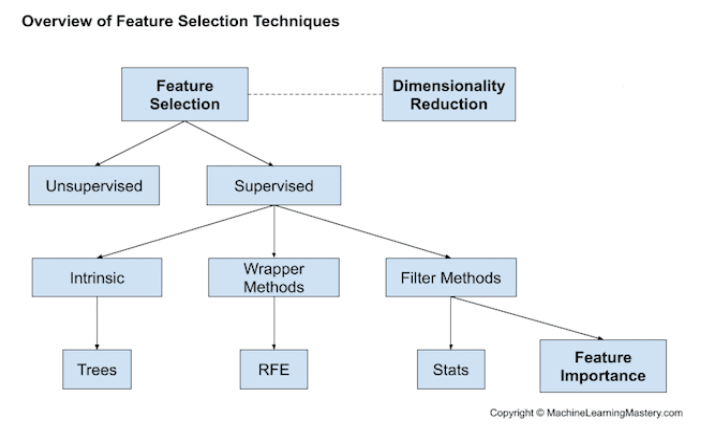

- PCA : 목표 변수가 없음 (Dimensionality Reduction)
    - input parameter 끼리의 상관관계만으로 fit, transform
- RFE : 목표 변수가 존재 (y값에 영향이 큰 변수 찾기)

RFE는 total bill을 예측하는지 아니면 tip을 예측하는지 등 y값에 따라 차원을 축소시키고 PCA는 y값과 관계없이 독립변수만으로 차원을 축소시킨다.

## 4-1. RFE
- 목표변수(y) : total_bill
- 독립변수(X) : tip, sex, smoker, day, time, size

In [10]:
data = tips.values
X = np.array(data[:, 1:], dtype=float) # train data
y = np.array(data[:, 0], dtype=float)

### 4-1-1. Linear Regression

In [11]:
from sklearn.feature_selection import RFE
# from sklearn.tree import DecisionTreeClassifier # 변수가 0, 1일 때 사용
from sklearn.linear_model import LinearRegression

rfe = RFE(estimator=LinearRegression(), n_features_to_select=4)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [12]:
x = [name for name in tips.columns if name not in ['total_bill']]
for i in range(X.shape[1]):
    print(f'{x[i]},\tRank: {rfe.ranking_[i]}')
# rfe.support_

tip,	Rank: 1
sex,	Rank: 2
smoker,	Rank: 1
day,	Rank: 3
time,	Rank: 1
size,	Rank: 1


### 4-1-2. SVR (Support Vector Regression)
- `kernel='linear'`로 줬기 때문에 Linear Regression과 같은 결과가 나온다.

In [13]:
from sklearn.svm import SVR

selector = RFE(estimator=SVR(kernel='linear'), n_features_to_select=4)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [14]:
x = [name for name in tips.columns if name not in ['total_bill']]
for i in range(X.shape[1]):
    print(f'{x[i]} \tRank: {rfe.ranking_[i]}')

tip 	Rank: 1
sex 	Rank: 2
smoker 	Rank: 1
day 	Rank: 3
time 	Rank: 1
size 	Rank: 1


# 5. Normalization / Standardization

## 5-1. Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler

trans = MinMaxScaler()
X_norm = trans.fit_transform(X)
X_norm = pd.DataFrame(X_norm, 
                      columns=[name for name in tips.columns if name != 'total_bill'])
X_norm.head(3)

,tip,sex,smoker,day,time,size
0,0.001111,0.0,0.0,0.666667,0.0,0.2
1,0.073333,1.0,0.0,0.666667,0.0,0.4
2,0.277778,1.0,0.0,0.666667,0.0,0.4


In [16]:
X_norm.describe().round(2)

,tip,sex,smoker,day,time,size
count,248.00,248.00,248.00,248.00,248.00,248.00
mean,0.22,0.65,0.38,0.58,0.27,0.32
std,0.15,0.48,0.49,0.31,0.45,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.11,0.00,0.00,0.33,0.00,0.20
50%,0.22,1.00,0.00,0.67,0.00,0.20
75%,0.28,1.00,1.00,0.75,1.00,0.40
max,1.00,1.00,1.00,1.00,1.00,1.00


## 5-2. Standardization

In [17]:
from sklearn.preprocessing import StandardScaler

trans = StandardScaler()
X_std = trans.fit_transform(X)
X_std = pd.DataFrame(X_std,
                    columns=[name for name in tips.columns if name != 'total_bill'])
X_std.head(3)

,tip,sex,smoker,day,time,size
0,-1.442272,-1.34840,-0.774597,0.284849,-0.614636,-0.603300
1,-0.969877,0.74162,-0.774597,0.284849,-0.614636,0.442983
2,0.367367,0.74162,-0.774597,0.284849,-0.614636,0.442983


In [18]:
X_std.describe().round(2)

,tip,sex,smoker,day,time,size
count,248.00,248.00,248.00,248.00,248.00,248.00
mean,-0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.45,-1.35,-0.77,-1.89,-0.61,-1.65
25%,-0.72,-1.35,-0.77,-0.80,-0.61,-0.60
50%,-0.03,0.74,-0.77,0.28,-0.61,-0.60
75%,0.38,0.74,1.29,0.56,1.63,0.44
max,5.09,0.74,1.29,1.37,1.63,3.58


## 4-2. PCA

In [19]:
from sklearn.decomposition import PCA

trans = PCA(n_components=4)
X_pca = trans.fit_transform(X)
X_pca[:5, :]

array([[-2.04142827, -0.27572057, -0.37267695,  0.23740871],
       [-0.97776508, -0.32563545, -1.0102352 , -0.49563405],
       [ 0.66877699, -0.23282862, -0.19947924, -0.50543266],
       [ 0.05649013, -0.09974271,  0.58868116, -0.62615533],
       [ 1.16973425, -0.42991893, -0.97080307,  0.46703182]])

## 4-3. SelectKBest - f_regression

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=4)
X_selected = fs.fit_transform(X, y)
X_selected[-5:, :]

array([[3.  , 0.  , 0.  , 2.  ],
       [1.01, 0.  , 0.  , 2.  ],
       [3.35, 1.  , 0.  , 3.  ],
       [3.35, 1.  , 0.  , 2.  ],
       [3.35, 1.  , 0.  , 5.  ]])

In [21]:
x = [name for name in tips.columns if name not in ['total_bill']]
for i in range(X.shape[1]):
    print(f'{x[i]} \tScore: {fs.scores_[i]:.4}')
# fs.get_support()

tip 	Score: 205.4
sex 	Score: 5.39
smoker 	Score: 1.805
day 	Score: 0.4836
time 	Score: 8.47
size 	Score: 132.0


## 목표변수(y)를 tip으로, tip_rate라는 파생변수를 넣어 반복

In [29]:
tips['tip_rate'] = tips['tip'] / tips['total_bill'] *100
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,0.0,0.0,2.0,0.0,2.0,5.944673
1,10.34,1.66,1.0,0.0,2.0,0.0,3.0,16.054159
2,21.01,3.5,1.0,0.0,2.0,0.0,3.0,16.658734


In [30]:
data = tips.values
ix = [i for i in range(data.shape[1]) if i != 1]
X = np.array(data[:, ix], dtype=float)
y = np.array(data[:, 1], dtype=float)

#### 1. RFE

In [31]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=4)
rfe.fit(X, y)
X_rfe = rfe.transform(X)
X_rfe[:3,:]

array([[16.99      ,  0.        ,  0.        ,  5.94467334],
       [10.34      ,  0.        ,  0.        , 16.05415861],
       [21.01      ,  0.        ,  0.        , 16.65873394]])

In [32]:
x = [name for name in tips.columns if name not in ['tip']]
for i in range(X.shape[1]):
    print(f'{x[i]}     \tRank: {rfe.ranking_[i]}')

total_bill     	Rank: 1
sex     	Rank: 4
smoker     	Rank: 1
day     	Rank: 2
time     	Rank: 1
size     	Rank: 3
tip_rate     	Rank: 1


#### 2. Select-KBest

In [33]:
fs = SelectKBest(score_func=f_regression, k=4)
X_selected = fs.fit_transform(X, y)
X_selected[:3, :]

array([[16.99      ,  0.        ,  2.        ,  5.94467334],
       [10.34      ,  0.        ,  3.        , 16.05415861],
       [21.01      ,  0.        ,  3.        , 16.65873394]])

In [34]:
x = [name for name in tips.columns if name not in ['tip']]
for i in range(X.shape[1]):
    print(f'{x[i]}     \tScore: {fs.scores_[i]:.4}')

total_bill     	Score: 205.4
sex     	Score: 2.385
smoker     	Score: 0.01571
day     	Score: 0.05159
time     	Score: 3.534
size     	Score: 75.96
tip_rate     	Score: 34.04


#### 3. PCA

In [35]:
trans = PCA(n_components=4)
X_pca = trans.fit_transform(X)
X_pca[:5, :]

array([[ -0.89667671, -10.45190407,   0.17217355,  -0.25108053],
       [  8.80197148,  -3.27776397,   0.34815553,   1.08097065],
       [ -0.95479012,   1.02038376,   0.28350321,   0.37581152],
       [ -4.3324561 ,  -0.58947554,   0.06047672,  -0.72439798],
       [ -5.04577045,   0.45325068,   0.53409277,   1.06807752]])